In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import jax.random as jr
from typing import NamedTuple
from flax.training import train_state
import optax
import flax.linen as nn
import matplotlib.pyplot as plt

import sys
sys.path.append('../../')

from mcjax.proba.density import LogDensity
from mcjax.process.ou import OU
from mcjax.proba.gaussian import IsotropicGauss, MixedIsotropicGauss
from mcjax.proba.banana2d import Banana2D

from mcjax.process.dds import MLPModel,train_step, generate_samples


Available devices: [CpuDevice(id=0)]


In [2]:
# Parameters initialization
K = 1000
ou_sigma = 1.0
learning_rate = 1e-4
batch_size = 128
num_steps = 200_000
data_dim = 1

timesteps = jnp.arange(K, dtype=jnp.float32)
beta_start, beta_end = 0.1, 20.0
beta = beta_start + (beta_end - beta_start) * (timesteps / (K - 1))
alpha = 1.0 - jnp.exp(-2.0 * beta / K)

### Forward process

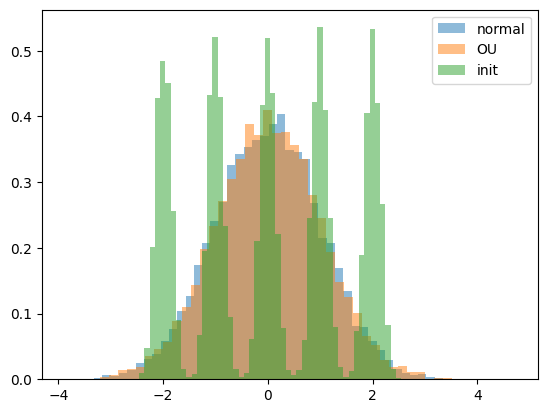

In [3]:
# Test the forward process
# init_dist = IsotropicGauss(mu=jnp.ones(data_dim), log_var=3.0)
# init_dist = Banana2D()
mu = jnp.array([[-2.],[-1.],[0.], [1.], [2.]])
dist_sigma = jnp.array([0.15, 0.15, 0.15, 0.15, 0.15])
log_var = jnp.log(dist_sigma**2)
weights = jnp.array([0.2, 0.2, 0.2, 0.2, 0.2])
init_dist = MixedIsotropicGauss(mu=mu, log_var=log_var, weights=weights)


key = jr.PRNGKey(0)
key, key_ = jr.split(key)
ou = OU(alpha=alpha, sigma=ou_sigma, init_dist=init_dist)
xK = ou.sample(key_, 10000, K)
normal_dist = IsotropicGauss(mu=jnp.zeros(data_dim), log_var=jnp.log(ou_sigma**2))

# Plot the initial distribution, final distribution and the normal distribution
key, key_ = jr.split(key)
x_normal = normal_dist.sample(key, 10000)
key, key_ = jr.split(key)
x_init = init_dist.sample(key, 10000)
plt.hist(x_normal, bins=50, density=True, label='normal', alpha= 0.5)
plt.hist(xK, bins=50, density=True, label='OU', alpha= 0.5)
plt.hist(x_init, bins=50, density=True, label='init', alpha= 0.5)
# plt.scatter(xK[:,0], xK[:,1], label='OU', alpha= 0.5)
plt.legend()

### Diffusion Denoising Sampler

In [33]:
# Diffusion Process Parameters
K = 1000
ou_sigma = 1.0
data_dim = 1
timesteps = jnp.arange(K, dtype=jnp.float32)
beta_start, beta_end = 0.1, 20.0
beta = beta_start + (beta_end - beta_start) * (timesteps / (K - 1))
alpha = 1.0 - jnp.exp(-2.0 * beta / K)

# Define the initial distribution of reference process
init_dist = IsotropicGauss(mu=jnp.zeros(data_dim), log_var=0.0)

# target distribution is a mixture of 2 gaussians
mu = jnp.array([[0.],[2.]])
dist_sigma = jnp.array([1., 2.])
log_var = jnp.log(dist_sigma**2)
weights = jnp.array([0.2, 0.8])
target_dist = MixedIsotropicGauss(mu=mu, log_var=log_var, weights=weights)

# Define the dynamic of the process
ou = OU(alpha=alpha, sigma=ou_sigma, init_dist=init_dist)

In [34]:
# Model Initialization
model = MLPModel(dim=1, T=K)

# network initialization
key = jr.PRNGKey(0)
key, key_ = jr.split(key)
dummy_x = jnp.zeros((1, data_dim))
dummy_t = jnp.zeros((1,), dtype=jnp.int32)
params = model.init(key_, dummy_x, dummy_t)

# optimizer initialization  
optimizer = optax.adam(learning_rate)
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer
)


In [35]:
# score function
def score_fn(params, k, y):
    batch_t = jnp.full((y.shape[0],), k, dtype=jnp.int32)
    return model.apply(params, y, batch_t)

In [38]:
def scan_step(carry, step):
        state, key = carry
        key, key_ = jr.split(key)
        state, loss = train_step(state, key_, ou, init_dist, target_dist, score_fn, batch_size)
            # every 100 steps, print step and current loss
        def do_print(_):
            jax.debug.print("At step {}, loss = {}", step, loss)
            return None

        # branch on (step % 100 == 0)
        _ = jax.lax.cond((step % 100) == 0, do_print, lambda _: None, operand=None)
        return (state, key), loss

def run_training(state, key):
    (final_state, final_key), losses = jax.lax.scan(
        scan_step,
        (state, key),
        jnp.arange(num_steps)
    )
    return final_state, final_key, losses

In [ ]:
# Training parameters
learning_rate = 1e-4
batch_size = 128
num_steps = 1000


# Training loop
key, key_ = jr.split(key)
state, key, losses = run_training(state, key_)


# Plot the loss curve
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.savefig('loss_curve.png')

# Sample the target process
key, key_ = jr.split(key) 
y_seq = generate_samples(
        state.params,
        score_fn,
        ou,
        num_samples=1000,
        key=key_,
)

y_seq = jax.device_get(y_seq)
dataset = target_dist.sample(key_, 10000)

# plot the last distribution of y_seq against dataset
plt.figure(figsize=(8, 4))
plt.hist(dataset, bins=30, density=True, alpha=0.5, label='Target Distribution')
plt.hist(y_seq[-1], bins=30, density=True, alpha=0.5, label='Final Samples')
plt.hist(y_seq[0], bins=30, density=True, alpha=0.5, label='Initial Samples')
plt.hist(y_seq[K//2], bins=30, density=True, alpha=0.5, label='Middle Samples')
plt.title('Generated Samples vs Target Distribution')
plt.legend()
plt.savefig('generated_samples.png')


At step 0, loss = 2063.86083984375
At step 100, loss = 16.23408317565918
At step 200, loss = 6.941190719604492


In [6]:
a = jnp.array([1,2,3])
b = jnp.array([4,5,6])
m = [(i,j) for (i,j) in zip(a,b)]
print(m)
key, keys = jr.split(key, num=6)
print(keys)



[(Array(1, dtype=int32), Array(4, dtype=int32)), (Array(2, dtype=int32), Array(5, dtype=int32)), (Array(3, dtype=int32), Array(6, dtype=int32))]


ValueError: too many values to unpack (expected 2)